In [428]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey

# File path and sheet details
file_path = 'test_gwp.xlsx'  # Use your specific file path if different
sheet_name = 'Upstream tree'  # Sheet name provided
#data_range = 'M:U'  # Specified data range

# Read the Excel file
df = pd.read_excel(file_path, sheet_name=sheet_name, 
                   #usecols=data_range,
                    skiprows=1)

res_name = [c for c in df.columns if "Result" in c][0]
df.rename(columns={res_name:"Result"}, inplace=True)
direc_cont =  [c for c in df.columns if "Direct contribution" in c][0]
df.drop(direc_cont, axis=1, inplace=True)

df = df[df['Result'] > 0]
df.dropna(axis=1, how='all', inplace=True)
df.reset_index(drop=True, inplace=True)
# Shorten the text to the first 10 characters for all cells
df = df.applymap(lambda x: x[:15] if isinstance(x, str) else x)
df = df.fillna("X")
df

,Processes,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Result
0,6.Transported f,X,X,X,X,X,X,174.648094
1,X,5.Filled Bottle,X,X,X,X,X,170.407407
2,X,X,4.Transported I,X,X,X,X,169.021520
3,X,X,X,3.Intermediate,X,X,X,167.986235
4,X,X,X,X,2.Transported G,X,X,105.666120
5,X,X,X,X,X,1.Granulates,X,104.630835
6,X,X,X,X,X,X,Polyethylene te,102.668939
7,X,X,X,X,X,X,Polyethylene hi,2.171778
8,X,X,X,X,X,Lorry transport,X,1.035285
9,X,X,X,X,Electricity gri,X,X,62.320115


In [429]:
## remove negatives
# Filter out negative values

def calculate_level(row):
    # Count the number of consecutive 'X' before the first non-'X'
    level = 0
    for value in row:
        if value == 'X':
            level += 1
        else:
            break
    return level
if "Level" not in df.columns:
    df['Level'] = df.apply(calculate_level, axis=1)


In [430]:

def create_source(df):
    return df.index.tolist()  # Source is simply the index

def create_target(df):
    target = []
    for i in range(len(df)):
        current_level = df['Level'].iloc[i]
        
        # Check if it's the first row
        if i == 0:
            target.append(None)  # No target for the first row
            continue
        
        previous_level = df['Level'].iloc[i - 1]

        if current_level == previous_level + 1:
            # Connect to the previous row
            target.append(i - 1)  # Target is the previous row index
        else:
            # Find the closest previous row with a lower level
            found_target = None
            for j in range(i, -1, -1):
                if df['Level'].iloc[j] < current_level:
                    found_target = j
                    break
            target.append(found_target)

    return target

# Create the Source and Target columns
df['Source'] = create_source(df)
df['Target'] = create_target(df)

# Display the updated DataFrame
df


,Processes,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Result,Level,Source,Target
0,6.Transported f,X,X,X,X,X,X,174.648094,0,0,NaN
1,X,5.Filled Bottle,X,X,X,X,X,170.407407,1,1,0.0
2,X,X,4.Transported I,X,X,X,X,169.021520,2,2,1.0
3,X,X,X,3.Intermediate,X,X,X,167.986235,3,3,2.0
4,X,X,X,X,2.Transported G,X,X,105.666120,4,4,3.0
5,X,X,X,X,X,1.Granulates,X,104.630835,5,5,4.0
6,X,X,X,X,X,X,Polyethylene te,102.668939,6,6,5.0
7,X,X,X,X,X,X,Polyethylene hi,2.171778,6,7,5.0
8,X,X,X,X,X,Lorry transport,X,1.035285,5,8,4.0
9,X,X,X,X,Electricity gri,X,X,62.320115,4,9,3.0


In [431]:
# Define a function to extract flow names
def extract_flows(row):
    # Check each column and return the first non-'X' value
    for value in row:
        if value != 'X':
            return value
    return None
df['Flow'] = df.apply(extract_flows, axis=1)

# Create a mapping for flow names to unique source indices
unique_flows = df['Flow'].unique()


df_flows = pd.DataFrame(unique_flows)
df_flows

,0
0,6.Transported f
1,5.Filled Bottle
2,4.Transported I
3,3.Intermediate
4,2.Transported G
5,1.Granulates
6,Polyethylene te
7,Polyethylene hi
8,Lorry transport
9,Electricity gri


In [432]:


df['Target Name'] = df['Target'].apply(lambda x: df['Flow'].iloc[int(x)] if pd.notna(x) else None)
df['Source Name'] = df['Source'].apply(lambda x: df['Flow'].iloc[int(x)] if pd.notna(x) else None)

df['Source ID'] = df['Source Name'].apply(lambda x: df_flows[df_flows[0] == x].index[0] if pd.notna(x) else None)
df['Target ID'] = df['Target Name'].apply(lambda x: df_flows[df_flows[0] == x].index[0] if pd.notna(x) else None)


In [433]:
df

,Processes,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Result,Level,Source,Target,Flow,Target Name,Source Name,Source ID,Target ID
0,6.Transported f,X,X,X,X,X,X,174.648094,0,0,NaN,6.Transported f,None,6.Transported f,0,NaN
1,X,5.Filled Bottle,X,X,X,X,X,170.407407,1,1,0.0,5.Filled Bottle,6.Transported f,5.Filled Bottle,1,0.0
2,X,X,4.Transported I,X,X,X,X,169.021520,2,2,1.0,4.Transported I,5.Filled Bottle,4.Transported I,2,1.0
3,X,X,X,3.Intermediate,X,X,X,167.986235,3,3,2.0,3.Intermediate,4.Transported I,3.Intermediate,3,2.0
4,X,X,X,X,2.Transported G,X,X,105.666120,4,4,3.0,2.Transported G,3.Intermediate,2.Transported G,4,3.0
5,X,X,X,X,X,1.Granulates,X,104.630835,5,5,4.0,1.Granulates,2.Transported G,1.Granulates,5,4.0
6,X,X,X,X,X,X,Polyethylene te,102.668939,6,6,5.0,Polyethylene te,1.Granulates,Polyethylene te,6,5.0
7,X,X,X,X,X,X,Polyethylene hi,2.171778,6,7,5.0,Polyethylene hi,1.Granulates,Polyethylene hi,7,5.0
8,X,X,X,X,X,Lorry transport,X,1.035285,5,8,4.0,Lorry transport,2.Transported G,Lorry transport,8,4.0
9,X,X,X,X,Electricity gri,X,X,62.320115,4,9,3.0,Electricity gri,3.Intermediate,Electricity gri,9,3.0


In [434]:

df2 = df[["Result", "Source Name", "Target Name"]]

df2


,Result,Source Name,Target Name
0,174.648094,6.Transported f,None
1,170.407407,5.Filled Bottle,6.Transported f
2,169.021520,4.Transported I,5.Filled Bottle
3,167.986235,3.Intermediate,4.Transported I
4,105.666120,2.Transported G,3.Intermediate
5,104.630835,1.Granulates,2.Transported G
6,102.668939,Polyethylene te,1.Granulates
7,2.171778,Polyethylene hi,1.Granulates
8,1.035285,Lorry transport,2.Transported G
9,62.320115,Electricity gri,3.Intermediate


In [435]:
import plotly.graph_objects as go

# Prepare the data for the Sankey diagram
sources = df2['Source Name'].tolist()
targets = df2['Target Name'].tolist()
values = df2['Result'].tolist()

# Remove entries where 'Target Name' is None, since they don't have a target
sources_cleaned = []
targets_cleaned = []
values_cleaned = []
for source, target, value in zip(sources, targets, values):
    if target is not None:
        sources_cleaned.append(source)
        targets_cleaned.append(target)
        values_cleaned.append(value)

# Create a list of unique labels
labels = list(set(sources_cleaned + targets_cleaned))

# Map source and target names to their corresponding index in the labels list
source_indices = [labels.index(source) for source in sources_cleaned]
target_indices = [labels.index(target) for target in targets_cleaned]

# Create the Sankey diagram using Plotly
fig = go.Figure(go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = labels,
    ),
    link = dict(
        source = source_indices,  # Indices of the source nodes
        target = target_indices,  # Indices of the target nodes
        value = values_cleaned    # Flow values
    )
))

# Update layout and display the figure
fig.update_layout(title_text="Sankey Diagram", font_size=10)
fig.show()


In [436]:
# Prepare data for Sankey diagram
flows = unique_flows.tolist()
values = df['Result'].tolist()
sources = df['Source'].tolist()
targets = df['Target ID'].tolist()

In [437]:
# Create a mapping for flow names to indices
import plotly.graph_objects as go

flow_names = {name: index for index, name in enumerate(set(flows))}
flow_indices = [flow_names[flow] for flow in flows]

# Prepare data for the Sankey diagram
sankey_data = {
    'source': [sources[i] if targets[i] is not None else -1 for i in range(len(sources))],
    'target': [targets[i] if targets[i] is not None else -1 for i in range(len(targets))],
    'value': values,
    'flow': flow_names
}

# Create a color scale based on the values, ensuring RGB values are valid
max_value = max(values)
colors = []
for value in values:
    # Normalize the value to a range of 0-255 for RGB
    r = int((value / max_value) * 200)
    g = int((1 - (value / max_value)) * 220)
    b =  int((value / max_value) * 200) # Fixed green component for a consistent look
    colors.append(f'rgb({r}, {g}, {b})')



In [438]:


# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=df2["Flow"].unique(),
        color="blue",
        hovertemplate='%{label}<extra></extra>'
    ),
    link=dict(
        source=sankey_data['source'],
        target=sankey_data['target'],
        value=sankey_data['value'],
        color=colors,
        hovertemplate='%{source.label} → %{target.label}: %{value}<extra></extra>'
    )
))

# Update layout for better visualization
fig.update_layout(title_text="Sankey Diagram", font_size=16)

# Show the Sankey diagram
fig.show()

KeyError: 'Flow'

In [370]:

# Clean the data by removing "X" columns and keeping the 'Processes' and 'Result' columns
df_cleaned = df.drop(columns=[col for col in df.columns if 'X' in col])

# Separate the processes and results columns
processes = df_cleaned.iloc[:, 0].fillna(method='ffill')  # Forward fill to account for hierarchical structure
results = df_cleaned.iloc[:, -1].fillna(0)  # Replace any missing results with 0
results

0     0.0
1     0.0
2     1.0
3     2.0
4     3.0
5     4.0
6     5.0
7     5.0
8     4.0
9     3.0
10    8.0
11    2.0
12    1.0
13    0.0
Name: Target ID, dtype: float64

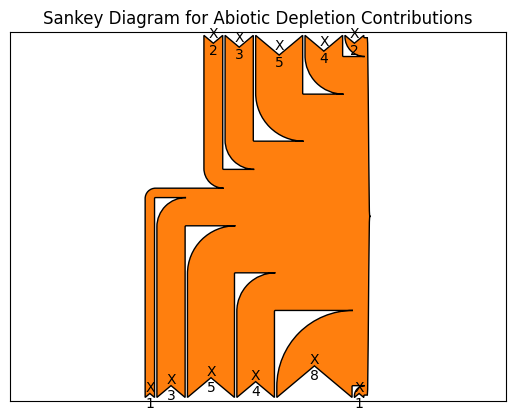

In [371]:

# Ignore negative values in the results by converting them to 0
results = results.apply(lambda x: x if x > 0 else 0)

# Define levels based on indentation (or 'X') to represent hierarchy
def get_level(process):
    return len(process) - len(process.lstrip("X"))

df_cleaned['Level'] = df_cleaned.iloc[:, 0].apply(get_level)

# Group the processes by levels to define the Sankey structure
levels = df_cleaned['Level'].unique()
process_dict = {level: df_cleaned[df_cleaned['Level'] == level].iloc[:, 0].tolist() for level in levels}
result_dict = {level: df_cleaned[df_cleaned['Level'] == level].iloc[:, -1].tolist() for level in levels}

# Plot the Sankey diagram
sankey = Sankey()

for level in levels:
    flows = result_dict[level]
    labels = process_dict[level]
    orientations = [1 if i % 2 == 0 else -1 for i in range(len(flows))]  # Alternate flow orientations for clarity
    sankey.add(flows=flows, labels=labels, orientations=orientations)

# Finish and display the diagram
sankey.finish()
plt.title('Sankey Diagram for Abiotic Depletion Contributions')
plt.show()
